# Insincerity Classification using AWD-LSTM
Implementing AWD-LSTM [1] with fastai.

## Intializing libraries and dataset

In [1]:
import os
import numpy as np
import pandas as pd
from fastai.text import * 
from fastai.callbacks import CSVLogger
from shutil import copyfile

In [2]:
#Setting path for learner
path = Path(os.path.abspath(os.curdir))

In [3]:
# Create directory
dirName = 'models'
 
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  models  Created 


In [4]:
#copying files into working path
modelpath = Path('../input/awd-lstm-cls-1')

copyfile(modelpath/"models/clas-1.pth", path/"models/clas-1.pth")
copyfile(modelpath/"models/ft_enc1.pth", path/"models/ft_enc1.pth")
copyfile(modelpath/"data_clas_export.pkl", path/"data_clas_export.pkl")
copyfile(modelpath/"data_lm_export.pkl", path/"data_lm_export.pkl")

PosixPath('/kaggle/working/data_lm_export.pkl')

In [5]:
"""
#reading into pandas and renaming columns for easier api access
filepath = Path('../input/quora-insincere-questions-classification')
trn = pd.read_csv(filepath/'train.csv')
tst = pd.read_csv(filepath/'test.csv')

#For training language model, using both train and test data for more data to learn from
df = pd.concat([trn,tst], sort=False)
df.rename(columns={'target':'label', 'question_text':'text'},inplace=True)
df = df[['label','text']]
df.head(2)

#Simple 90-10 split into train/validation set
train = df[:int(len(df)*.9)]
valid = df[int(len(df)*.9):]

"""

"\n#reading into pandas and renaming columns for easier api access\nfilepath = Path('../input/quora-insincere-questions-classification')\ntrn = pd.read_csv(filepath/'train.csv')\ntst = pd.read_csv(filepath/'test.csv')\n\n#For training language model, using both train and test data for more data to learn from\ndf = pd.concat([trn,tst], sort=False)\ndf.rename(columns={'target':'label', 'question_text':'text'},inplace=True)\ndf = df[['label','text']]\ndf.head(2)\n\n#Simple 90-10 split into train/validation set\ntrain = df[:int(len(df)*.9)]\nvalid = df[int(len(df)*.9):]\n\n"

In [6]:
# Language model data
#data_lm = TextLMDataBunch.from_df(path, train, valid)
#data_lm.save('data_lm_export.pkl')

In [7]:
data_lm = load_data(path, 'data_lm_export.pkl')

In [8]:
#Training a language model, i.e. to predict the next few words
#learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, callback_fns=[partial(CSVLogger, append=True)])

In [9]:
#learn.lr_find()
#learn.recorder.plot()

In [10]:
#learn.fit_one_cycle(4, 1e-2)
#learn.save('fit_head'); learn.load('fit_head')

In [11]:
#learn.unfreeze()
#learn.lr_find(); learn.recorder.plot()

In [12]:
#learn.fit_one_cycle(4, 1e-3)
#learn.save_encoder('ft_enc1')

In [13]:
#learn.predict("Why are people", n_words=10)

In [14]:
"""
trn.rename(columns={'target':'label', 'question_text':'text'},inplace=True)
df = trn[['label','text']]

train = df[:int(len(df)*.80)]
valid = df[int(len(df)*.80):]
"""

"\ntrn.rename(columns={'target':'label', 'question_text':'text'},inplace=True)\ndf = trn[['label','text']]\n\ntrain = df[:int(len(df)*.80)]\nvalid = df[int(len(df)*.80):]\n"

In [15]:
data_clas = load_data(path, 'data_clas_export.pkl', bs=16)
# Classifier model data
#data_clas = TextClasDataBunch.from_df(path, train, valid, vocab=data_lm.train_ds.vocab, bs=16)
#data_clas.save('data_clas_export.pkl') ; data_clas = load_data(path, 'data_clas_export.pkl', bs=16)

In [16]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=.3, metrics=[accuracy, FBeta(beta=1, average='binary')],
                               callback_fns=[partial(CSVLogger, append=True)])
learn.load_encoder('ft_enc1') #encoder from first training has 42% accuracy in predicting next word

In [17]:
learn.load('clas-1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1044897 items)
x: TextList
xxbos xxmaj how did xxmaj quebec nationalists see their province as a nation in the 1960s ?,xxbos xxmaj do you have an adopted dog , how would you encourage people to adopt and not shop ?,xxbos xxmaj why does velocity affect time ? xxmaj does velocity affect space geometry ?,xxbos xxmaj how did xxmaj otto von xxmaj guericke used the xxmaj magdeburg hemispheres ?,xxbos xxmaj can i convert montra xxunk d to a mountain bike by just changing the tyres ?
y: CategoryList
0,0,0,0,0
Path: /kaggle/working;

Valid: LabelList (261225 items)
x: TextList
xxbos xxmaj what major political events happened in the 1960s ?,xxbos xxmaj are xxunk watches good ?,xxbos xxmaj was the xxup t-34 a quantity over quality tank ?,xxbos xxmaj if a mass will travel with velocity of light then the mass is converted in energy so what happen to the energy through which we acc to that velocity ?,xxbos xxmaj how come xxmaj gaara is so much st

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


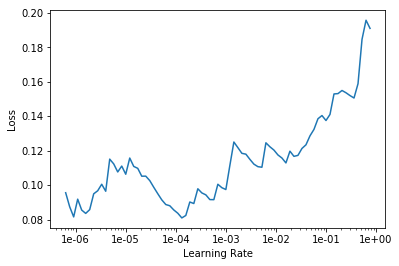

In [18]:
learn.lr_find(); learn.recorder.plot()

In [19]:
learn.fit_one_cycle(2, 1e-5)

epoch,train_loss,valid_loss,accuracy,f_beta,time


In [20]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1e-6/(2.6**4), 1e-6))

epoch,train_loss,valid_loss,accuracy,f_beta,time


In [21]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(1e-7/(2.6**4), 1e-7))

epoch,train_loss,valid_loss,accuracy,f_beta,time


In [22]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-8/(2.6**4),1e-8))

epoch,train_loss,valid_loss,accuracy,f_beta,time


In [23]:
learn.predict("Why are foreigners so lazy?")

(Category 1, tensor(1), tensor([0.0676, 0.9324]))

In [24]:
learn.predict("When was SMU founded and why?")

(Category 0, tensor(0), tensor([0.9878, 0.0122]))

In [25]:
learn.save('clas-2')

In [26]:
preds, y = learn.get_preds(DatasetType.Valid)

In [27]:
# https://www.kaggle.com/ryanzhang/tfidf-naivebayes-logreg-baseline

def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

In [28]:
y_proba = preds[:, -1:].detach().cpu().numpy()
y_true = y.detach().cpu().numpy()

In [29]:
from sklearn.metrics import f1_score

In [30]:
threshold_search(y_true, y_proba)

{'threshold': 0.3, 'f1': 0.6907446558609349}

## References
[1] Stephen Merity, Nitish Shirish Keskar, and Richard Socher. 2017. Regularizing and optimizing lstm language models.